# Importing Libraries

In [2]:
import pandas as pd
import re
import string

from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd



import nltk
from nltk import FreqDist
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


import unicodedata             ## to remove accented and special chracters

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/miladshirani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Functions we use

In [3]:
def visualize_top_word(freq_dist, number_of_word,title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(number_of_word)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

In [4]:
def tokenizing_lemmatizing(data):
    
    lemmatizer = WordNetLemmatizer()
    basic_token_pattern = r"(?u)\b\w\w+\b"
    tokenizer = RegexpTokenizer(basic_token_pattern)
    token_list = tokenizer.tokenize(data)
    
    
    return [lemmatizer.lemmatize(token.lower(), pos = "v") for token in token_list 
            if token.lower() not in stop_words and token.lower() != "sxsw"
           and token.lower() != "rt"]


In [5]:
def neg_finder(data):
    
    pattern = "\'t"
    
    return re.sub(pattern, " not", data)

In [6]:
test_data = """
I can't drive now, I haven't driven since yesterday, however, I won't drive tomorrow
either. I ain't want to drive anytime soon.
"""

neg_finder(test_data)

'\nI can not drive now, I haven not driven since yesterday, however, I won not drive tomorrow\neither. I ain not want to drive anytime soon.\n'

In [7]:
def id_finder(data):
    pattern = '@[a-zA-Z0-9]+'
    
    return re.sub(pattern," ",data)

In [8]:
def char_finder(data):
    pattern = r'[^a-zA-z0-9]'
    return re.sub(pattern," ",data)

In [9]:
def num_finder(data):
    """
    the pattern 
    
    "\+?\s?\d+.?\d+.?\d+.?\d+|\(\d+\) \d+.?\d+"
    
    can be used to get the digits, dates and phone numbers
    of the form
    
    12.2345  
    0.0123   
    9876  
    
    dates of the form:
    
    12/21/2020  
    2020-01-22  
    2020/02/23
    
    phone numbers of the form:
    
    (911) 820 2230
    (911) 820-223
    911-820-2230   
    +1-814-929-2533  
    0018149292533
    
    time of the form: 
    
    12:00
    
    """
    """
    To get phone numbers of the form 
    (XXX) XXX-XXX or XXX-XXX-XXXX or +X-XXX-XXX-XXXX
    
    we can use the following pattern
    "\+?\d+.\d+.\d+.\d+.\d+|\(\d+\) \d+.\d+"
    
    to get numbers of the form:
    XXX or XX.XXX
    we can use the following pattern
    "(\s\d+\s|\s\d+\.\d+\s)"
    
    """

#     pattern = "\d+|\s\+?\s?\d+.?\d+.?\d+.?\d+|\(\d+\) \d+.?\d+|\s+\d+" 
    pattern = "\s\d+\s"
    return re.sub(pattern, " ", data)

In [10]:
def accent_finder(data):
    new_data = unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_data

In [11]:
def cleaning(data, lemmatizing):
    data_lower = data.lower()
    no_neg  = neg_finder(data_lower)
    no_id   = id_finder(no_neg)
    no_char = char_finder(no_id)
    no_acc  = accent_finder(no_char)
    no_num  = num_finder(no_acc)
    
    if lemmatizing == True:
    
        return tokenizing_lemmatizing(no_num)
    
    else:
    
        return no_num

# Importing Data

We used the [this link](https://docs.python.org/3/library/codecs.html#standard-encodings) to find the correct encoding. 

In [17]:
df = pd.read_csv("data/judge-1377884607_tweet_product_company.csv", encoding = "cp437")

print(df.isnull().sum()/len(df) * 100)
df.drop("emotion_in_tweet_is_directed_at", axis = 1, inplace = True)
df.dropna(inplace = True)
print()
print()
print(df.isna().sum())

tweet_text                                             0.010997
emotion_in_tweet_is_directed_at                       63.807324
is_there_an_emotion_directed_at_a_brand_or_product     0.000000
dtype: float64


tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64


In [18]:
df.rename(columns={"tweet_text": "text",
                   "is_there_an_emotion_directed_at_a_brand_or_product":"label"},
         inplace = True)

print(df.label.value_counts())
print()

emotion = {"Negative emotion": "neg", "Positive emotion": "pos", 
          "No emotion toward brand or product": "neu",
          "I can't tell": "neg"}
df.label = df.label.map(emotion)

print(df.label.value_counts())

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: label, dtype: int64

neu    5388
pos    2978
neg     726
Name: label, dtype: int64


# Cleaning and Adding Sentiment Score by using NLTK

In [19]:
df["cleaned_text"] = df["text"].apply(lambda x: cleaning(x, False))

print("Initial Cleaning  --- > Done")

lemmatizer = WordNetLemmatizer()

df["lemmatized_text"] = df["cleaned_text"].apply(lambda x: cleaning(x, True))

print("Lemmatizing       --- > Done")

sid = SentimentIntensityAnalyzer()
sentiment_values = ['neg', 'neu', 'pos', 'compound']

df[sentiment_values] = df["text"].apply(lambda x: id_finder(x))\
.apply(sid.polarity_scores).apply(pd.Series)

print("Sentiment         --- > Done")

df.to_csv("../EDA/cleaned_data/cleaned.csv")

print("File Saved        --- > Done")


Initial Cleaning  --- > Done
Lemmatizing       --- > Done
Sentiment         --- > Done
File Saved        --- > Done


In [20]:
df.iloc[0]["text"]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [21]:
df.iloc[0]["cleaned_text"]

'   i have a 3g iphone  after hrs tweeting at  rise_austin  it was dead   i need to upgrade  plugin stations at  sxsw '

In [22]:
df.iloc[0]["lemmatized_text"]

['3g',
 'iphone',
 'hrs',
 'tweet',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station']

# Some Visualizations

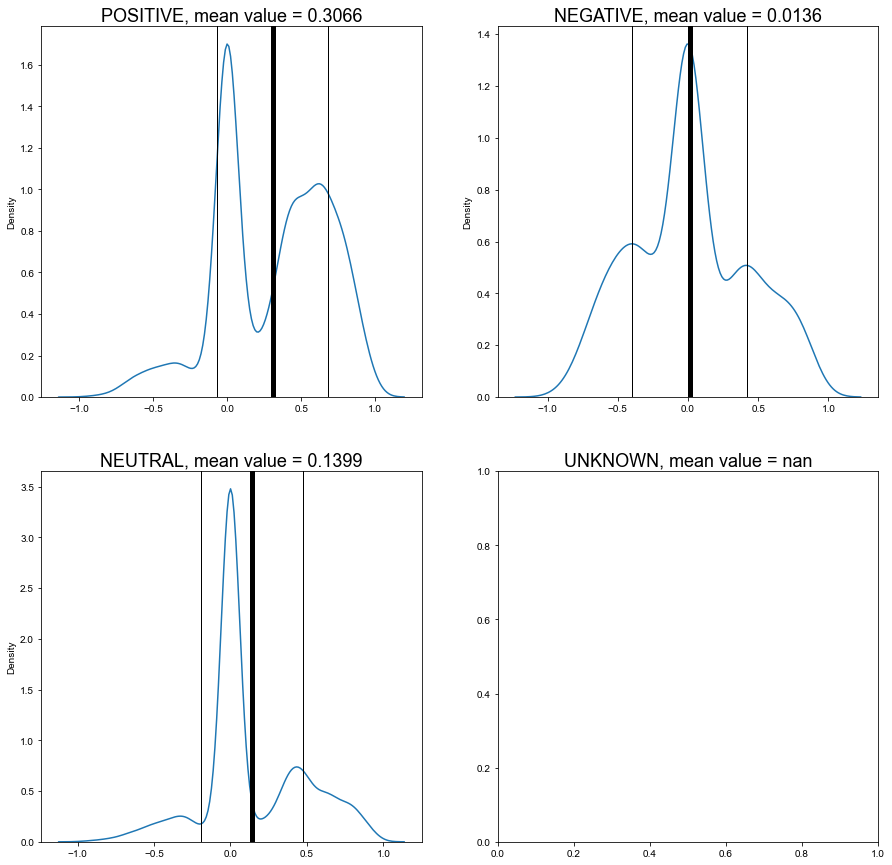

In [23]:
figs, axes = plt.subplots(nrows= 2 , ncols=2, figsize = (15, 15))

figs.subplots_adjust(hspace=0.2, wspace=0.2)
sns.set(font_scale=1.5)

labels = ["pos", "neg", "neu", "unknown"]
sentiment = ["positive", "negative", "neutral", "unknown"]


for i, item in enumerate(labels):
    ax = axes[i//2][i%2] 
    data = df[df["label"] == item]["compound"].values
    sns.kdeplot(data, ax = ax, 
                 color = "tab:blue"
               ).set(title=f"{sentiment[i].upper()}, mean value = {np.round(data.mean(), 4)}");
    vline = ax.axvline(data.mean(), 0,3, color = "black", lw = 5)
    ax.axvline(data.mean() + data.std(), 0,3, color = "black", lw = 1)
    ax.axvline(data.mean() - data.std(), 0,3, color = "black", lw = 1)
    

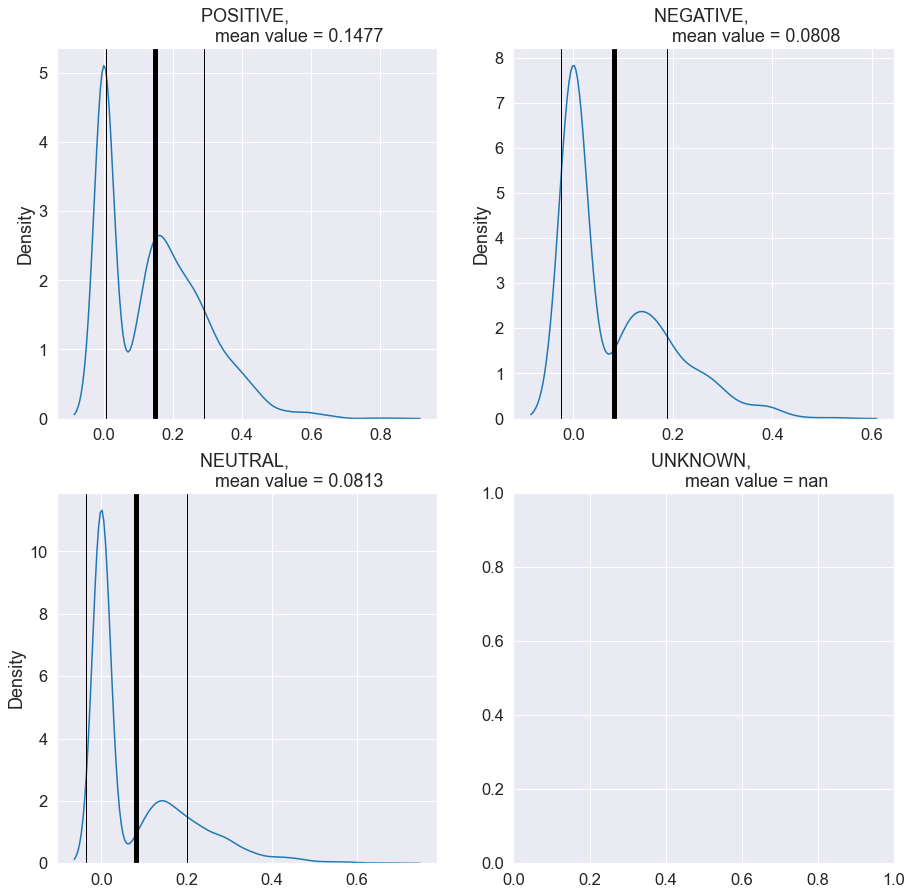

In [24]:
figs, axes = plt.subplots(nrows= 2 , ncols=2, figsize = (15, 15))

figs.subplots_adjust(hspace=0.2, wspace=0.2)
sns.set(font_scale=1.5)

labels = ["pos", "neg", "neu", "unknown"]
sentiment = ["positive", "negative", "neutral", "unknown"]


for i, item in enumerate(labels):
    ax = axes[i//2][i%2] 
    data = df[df["label"] == item]["pos"].values
    sns.kdeplot(data, ax = ax, 
                 color = "tab:blue"
               ).set(title=f"""{sentiment[i].upper()}, 
                     mean value = {np.round(data.mean(), 4)}""");
    ax.axvline(data.mean(), 0,3, color = "black", lw = 5)
    ax.axvline(data.mean() + data.std(), 0,3, color = "black", lw = 1)
    ax.axvline(data.mean() - data.std(), 0,3, color = "black", lw = 1)
    

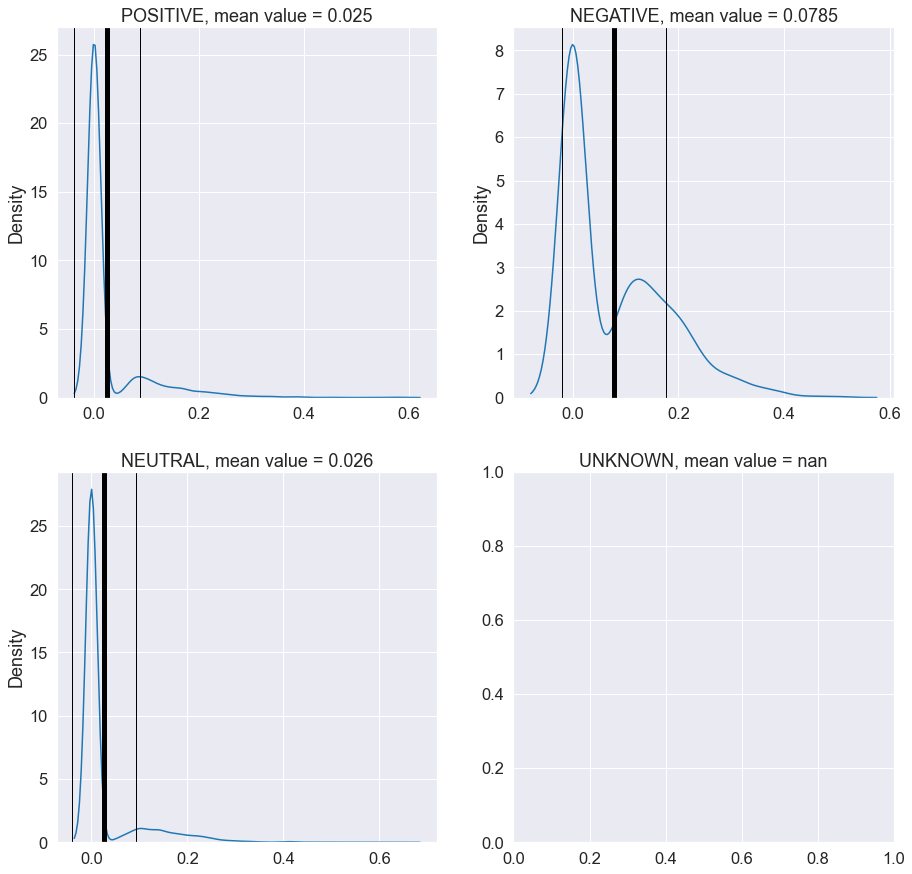

In [25]:
figs, axes = plt.subplots(nrows= 2 , ncols=2, figsize = (15, 15))

figs.subplots_adjust(hspace=0.2, wspace=0.2)
sns.set(font_scale=1.5)

labels = ["pos", "neg", "neu", "unknown"]
sentiment = ["positive", "negative", "neutral", "unknown"]


for i, item in enumerate(labels):
    ax = axes[i//2][i%2] 
    data = df[df["label"] == item]["neg"].values
    sns.kdeplot(data, ax = ax, 
                 color = "tab:blue"
               ).set(title=f"{sentiment[i].upper()}, mean value = {np.round(data.mean(), 4)}");
    vline = ax.axvline(data.mean(), 0,3, color = "black", lw = 5)
    ax.axvline(data.mean() + data.std(), 0,3, color = "black", lw = 1)
    ax.axvline(data.mean() - data.std(), 0,3, color = "black", lw = 1)
    

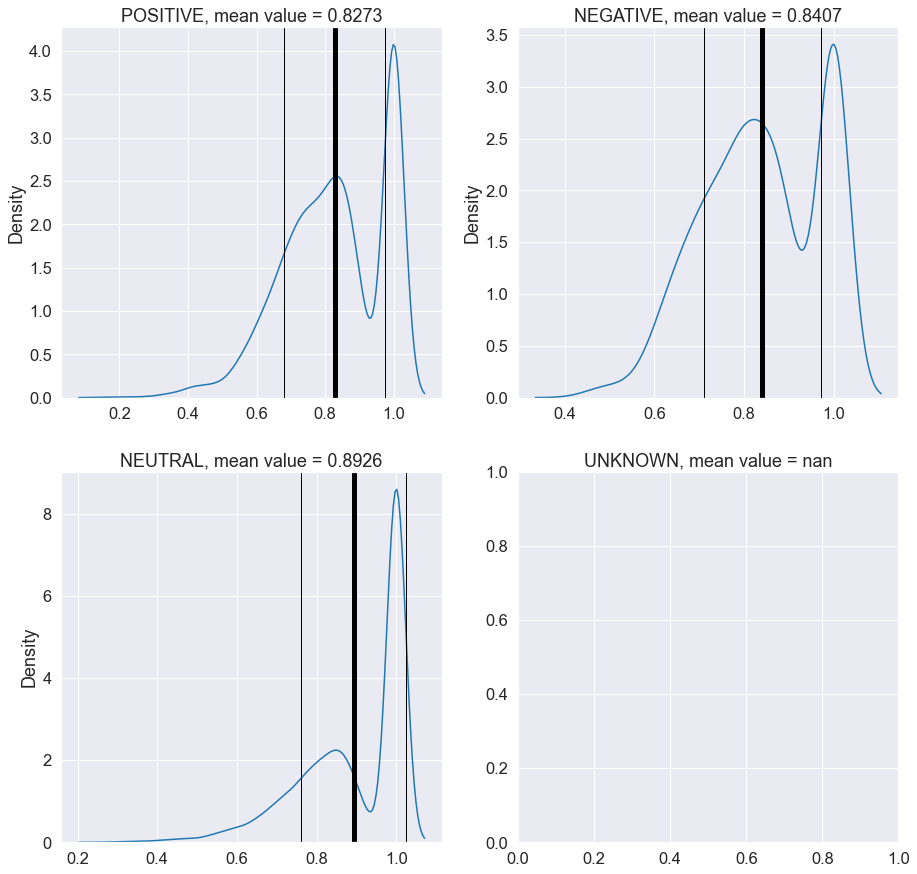

In [26]:
figs, axes = plt.subplots(nrows= 2 , ncols=2, figsize = (15, 15))

figs.subplots_adjust(hspace=0.2, wspace=0.2)
sns.set(font_scale=1.5)

labels = ["pos", "neg", "neu", "unknown"]
sentiment = ["positive", "negative", "neutral", "unknown"]


for i, item in enumerate(labels):
    ax = axes[i//2][i%2] 
    data = df[df["label"] == item]["neu"].values
    sns.kdeplot(data, ax = ax, 
                 color = "tab:blue"
               ).set(title=f"{sentiment[i].upper()}, mean value = {np.round(data.mean(), 4)}");
    vline = ax.axvline(data.mean(), 0,3, color = "black", lw = 5)
    ax.axvline(data.mean() + data.std(), 0,3, color = "black", lw = 1)
    ax.axvline(data.mean() - data.std(), 0,3, color = "black", lw = 1)
    

In [28]:
a = df["neg"].values
# b = df["neu"].values
c = df["pos"].values
d = df["compound"].values

tukey_df = pd.DataFrame({"score":list(a) + list(c) + list(d),
                         "groups": np.repeat(["a", "c", "d"], repeats = len(a))})

tukey = pairwise_tukeyhsd(endog=tukey_df['score'],
                          groups=tukey_df['groups'],
                          alpha=0.05)

#display results
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     a      c   0.0731 0.001 0.0652  0.081   True
     a      d   0.1545 0.001 0.1466 0.1624   True
     c      d   0.0814 0.001 0.0734 0.0893   True
-------------------------------------------------


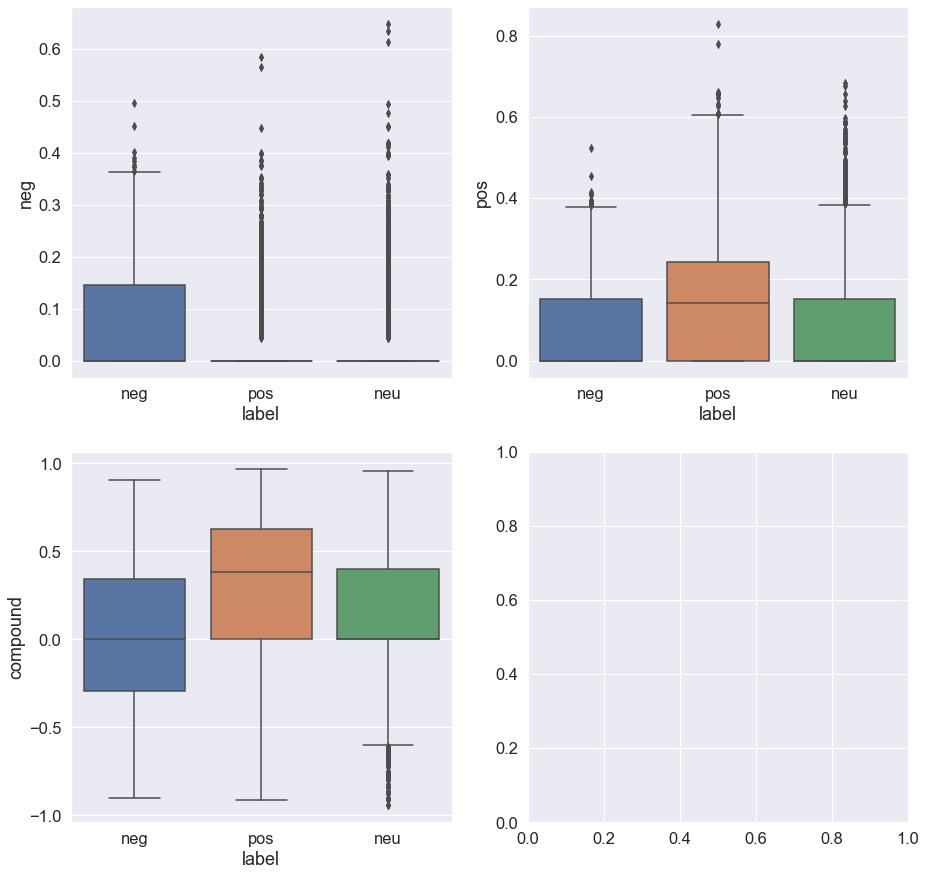

In [29]:
figs, axes = plt.subplots(nrows= 2 , ncols=2, figsize = (15, 15))

figs.subplots_adjust(hspace=0.2, wspace=0.2)
sns.set(font_scale=2)
list_of_items = ["neg", "pos", "compound"]

for i, item in enumerate(list_of_items):
    ax = axes[i//2][i%2]
    sns.boxplot(x = "label", y = item, data = df, ax = ax);


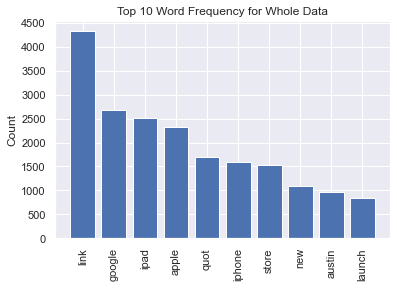

In [30]:
freq_dist = FreqDist(df["lemmatized_text"].explode())
freq_dist
sns.set(font_scale=1)
visualize_top_word(freq_dist, 10,"Top 10 Word Frequency for Whole Data")

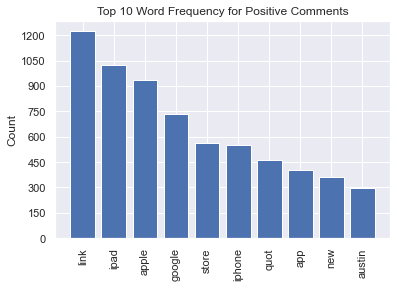

In [31]:
pos_freq_dist = FreqDist(df.loc[df["label"] == "pos","lemmatized_text"].explode())

sns.set(font_scale=1)
visualize_top_word(pos_freq_dist, 10,"Top 10 Word Frequency for Positive Comments")

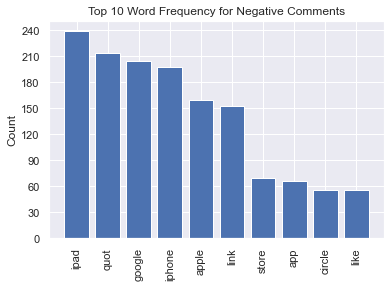

In [32]:
neg_freq_dist = FreqDist(df.loc[df["label"] == "neg","lemmatized_text"].explode())

sns.set(font_scale=1)
visualize_top_word(neg_freq_dist, 10,"Top 10 Word Frequency for Negative Comments")

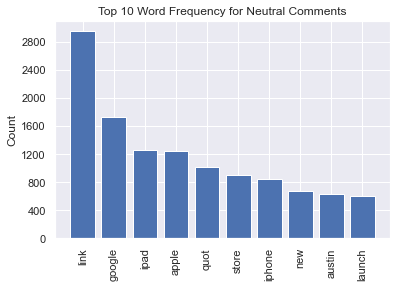

In [33]:
neu_freq_dist = FreqDist(df.loc[df["label"] == "neu","lemmatized_text"].explode())

sns.set(font_scale=1)
visualize_top_word(neu_freq_dist, 10,"Top 10 Word Frequency for Neutral Comments")